# **ICESat-2 ATL11 Rate of Height change over Time (dhdt)**

This Jupyter notebook will cover the calculation of
Ice Height Changes (dh) over Time (dt) using Linear Regression.
Focusing on the Antarctic continent, for the ICESat-2 time period.
To save on computational resources, we'll run through a few preprocessing steps:

1. Select essential points
  - Subset to geographic region of interest (optional)
  - Drop points without at least 2 valid heights across all ICESat-2 cycles
2. Calculate height range (h_range)
  - Done for points which are valid and in geographic region of interest
  - Uses the `deepicedrain.nanptp` function
3. Calculate rate of height change over time (dhdt)
  - Done for points with `h_range > 0.5 metres`
  - Uses the `deepicedrain.nan_linregress` function

Adapted from https://github.com/suzanne64/ATL11/blob/master/plotting_scripts/AA_dhdt_map.ipynb

In [1]:
import dask
import datashader
import numpy as np
import pandas as pd
import pygmt
import scipy.stats
import xarray as xr

import deepicedrain

In [2]:
client = dask.distributed.Client(n_workers=64, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:43825 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 201.22 GB


# Select essential points

In [3]:
# Load ATL11 data from Zarr
ds: xr.Dataset = xr.open_mfdataset(
    paths="ATL11.001z123/ATL11_*.zarr",
    chunks={"cycle_number": 6},
    engine="zarr",
    combine="nested",
    concat_dim="ref_pt",
    parallel="True",
    backend_kwargs={"consolidated": True},
)

## Light pre-processing

- Reproject longitude/latitude to EPSG:3031 x/y
- Mask out low quality height data

In [4]:
# Calculate the EPSG:3031 x/y projection coordinates
ds["x"], ds["y"] = deepicedrain.lonlat_to_xy(
    longitude=ds.longitude, latitude=ds.latitude
)
# Set x and y as coordinates of the xarray.Dataset
ds: xr.Dataset = ds.set_coords(names=["x", "y"])

In [5]:
# Mask out low quality height data
ds["h_corr"]: xr.DataArray = ds.h_corr.where(cond=ds.quality_summary_ref_surf == 0)

## Trim out unnecessary values

There's ~150 million ATL11 points for the whole of Antarctica,
and not all of them will be needed depending on what you want to do.
To cut down on the number of data points the computer needs to work on,
we can:

- Subset to geographic region of interest (optional)
- Ensure there are at least 2 height values to calculate trend over time

In [6]:
# Dictionary of Antarctic bounding box locations with EPSG:3031 coordinates
regions: dict = {
    "kamb": deepicedrain.Region(
        name="Kamb Ice Stream",
        xmin=-411054.19240523444,
        xmax=-365489.6822096751,
        ymin=-739741.7702261859,
        ymax=-699564.516934089,
    ),
    "antarctica": deepicedrain.Region(
        "Antarctica", -2700000, 2800000, -2200000, 2300000
    ),
    "siple_coast": deepicedrain.Region(
        "Siple Coast", -1000000, 250000, -1000000, -100000
    ),
    "whillans": deepicedrain.Region(
        "Whillans Ice Stream", -350000, -100000, -700000, -450000
    ),
    "whillans2": deepicedrain.Region(
        "Whillans Ice Stream", -500000, -400000, -600000, -500000
    ),
}

In [7]:
# Subset dataset to geographic region of interest (optional!)
placename: str = "antarctica"
region: deepicedrain.Region = regions[placename]
# ds = region.subset(ds=ds)

In [8]:
# We need at least 2 points to draw a trend line or compute differences
# So let's drop points with less than 2 valid values across all cycles
# Will take maybe 5-10 min to trim down ~150 million points to ~100 million
ds: xr.Dataset = ds.dropna(dim="ref_pt", thresh=2, subset=["h_corr"])
print(f"Trimmed to {len(ds.ref_pt)} points")

Trimmed to 105304336 points


### Optimize dataset for big calculations later

We'll rechunk the dataset to a reasonable chunk size,
and persist the dataset in memory so that the parallel
computations will be more efficient in later sections.

In [9]:
ds["h_corr"] = ds.h_corr.unify_chunks()

In [10]:
# Persist the height data in distributed memory
ds["h_corr"] = ds.h_corr.persist()

# Calculate height range (h_range)

A simple way of finding active subglacial lakes is to see where
there has been a noticeably rapid change in elevation over
a short period of time (e.g. 2-5 metres a year, or ~4 ICESat-2 cycles).
'Range of height' is quick way to do this,
basically just doing maximum height minus minimum height.

In [11]:
# Calculate height range across cycles, parallelized using dask
ds["h_range"]: xr.DataArray = xr.apply_ufunc(
    deepicedrain.nanptp,  # min point to max point (range) that handles NaN values
    ds.h_corr,
    input_core_dims=[["cycle_number"]],
    dask="allowed",
    output_dtypes=[ds.h_corr.dtype],
    kwargs={"axis": 1},
)

In [12]:
# %%time
# Compute height range. Also include all height and time info
ds_ht: xr.Dataset = ds[["h_range", "h_corr", "delta_time"]].compute()

CPU times: user 7min 8s, sys: 1min 23s, total: 8min 31s
Wall time: 7min 43s


In [13]:
# Non-parallelized
# h_range = deepicedrain.nanptp(a=ds.h_corr[0:1], axis=1)
# Ensure no height range values which are zero (usually due to only 1 data point)
# assert len(dask.array.argwhere(dsh.h_range <= 0.0).compute()) == 0

In [14]:
# Save or Load height range data
# ds_ht.to_zarr(store=f"ATLXI/ds_hrange_time_{placename}.zarr", mode="w", consolidated=True)
ds_ht: xr.Dataset = xr.open_dataset(
    filename_or_obj=f"ATLXI/ds_hrange_time_{placename}.zarr",
    chunks={"cycle_number": 6},
    engine="zarr",
    backend_kwargs={"consolidated": True},
)
# ds: xr.Dataset = ds_ht  # shortcut for later steps

In [15]:
df_hr: pd.DataFrame = ds_ht.h_range.to_dataframe()

In [16]:
df_hr.describe()

,x,y,h_range
count,1.053043e+08,1.053043e+08,1.053043e+08
mean,3.093880e+05,7.607347e+04,2.794175e-01
std,1.004571e+06,9.069758e+05,1.960541e+01
min,-4.363550e+06,-2.550290e+06,1.152330e-09
25%,-3.440945e+05,-5.512373e+05,4.350719e-02
50%,2.413311e+05,6.712119e+04,8.278716e-02
75%,1.069470e+06,6.978134e+05,1.758788e-01
max,3.991056e+06,3.984938e+06,8.951829e+04


In [ ]:
# Datashade our height values (vector points) onto a grid (raster image)
agg_grid: xr.DataArray = region.datashade(df=df_hr, z_dim="h_range")
agg_grid

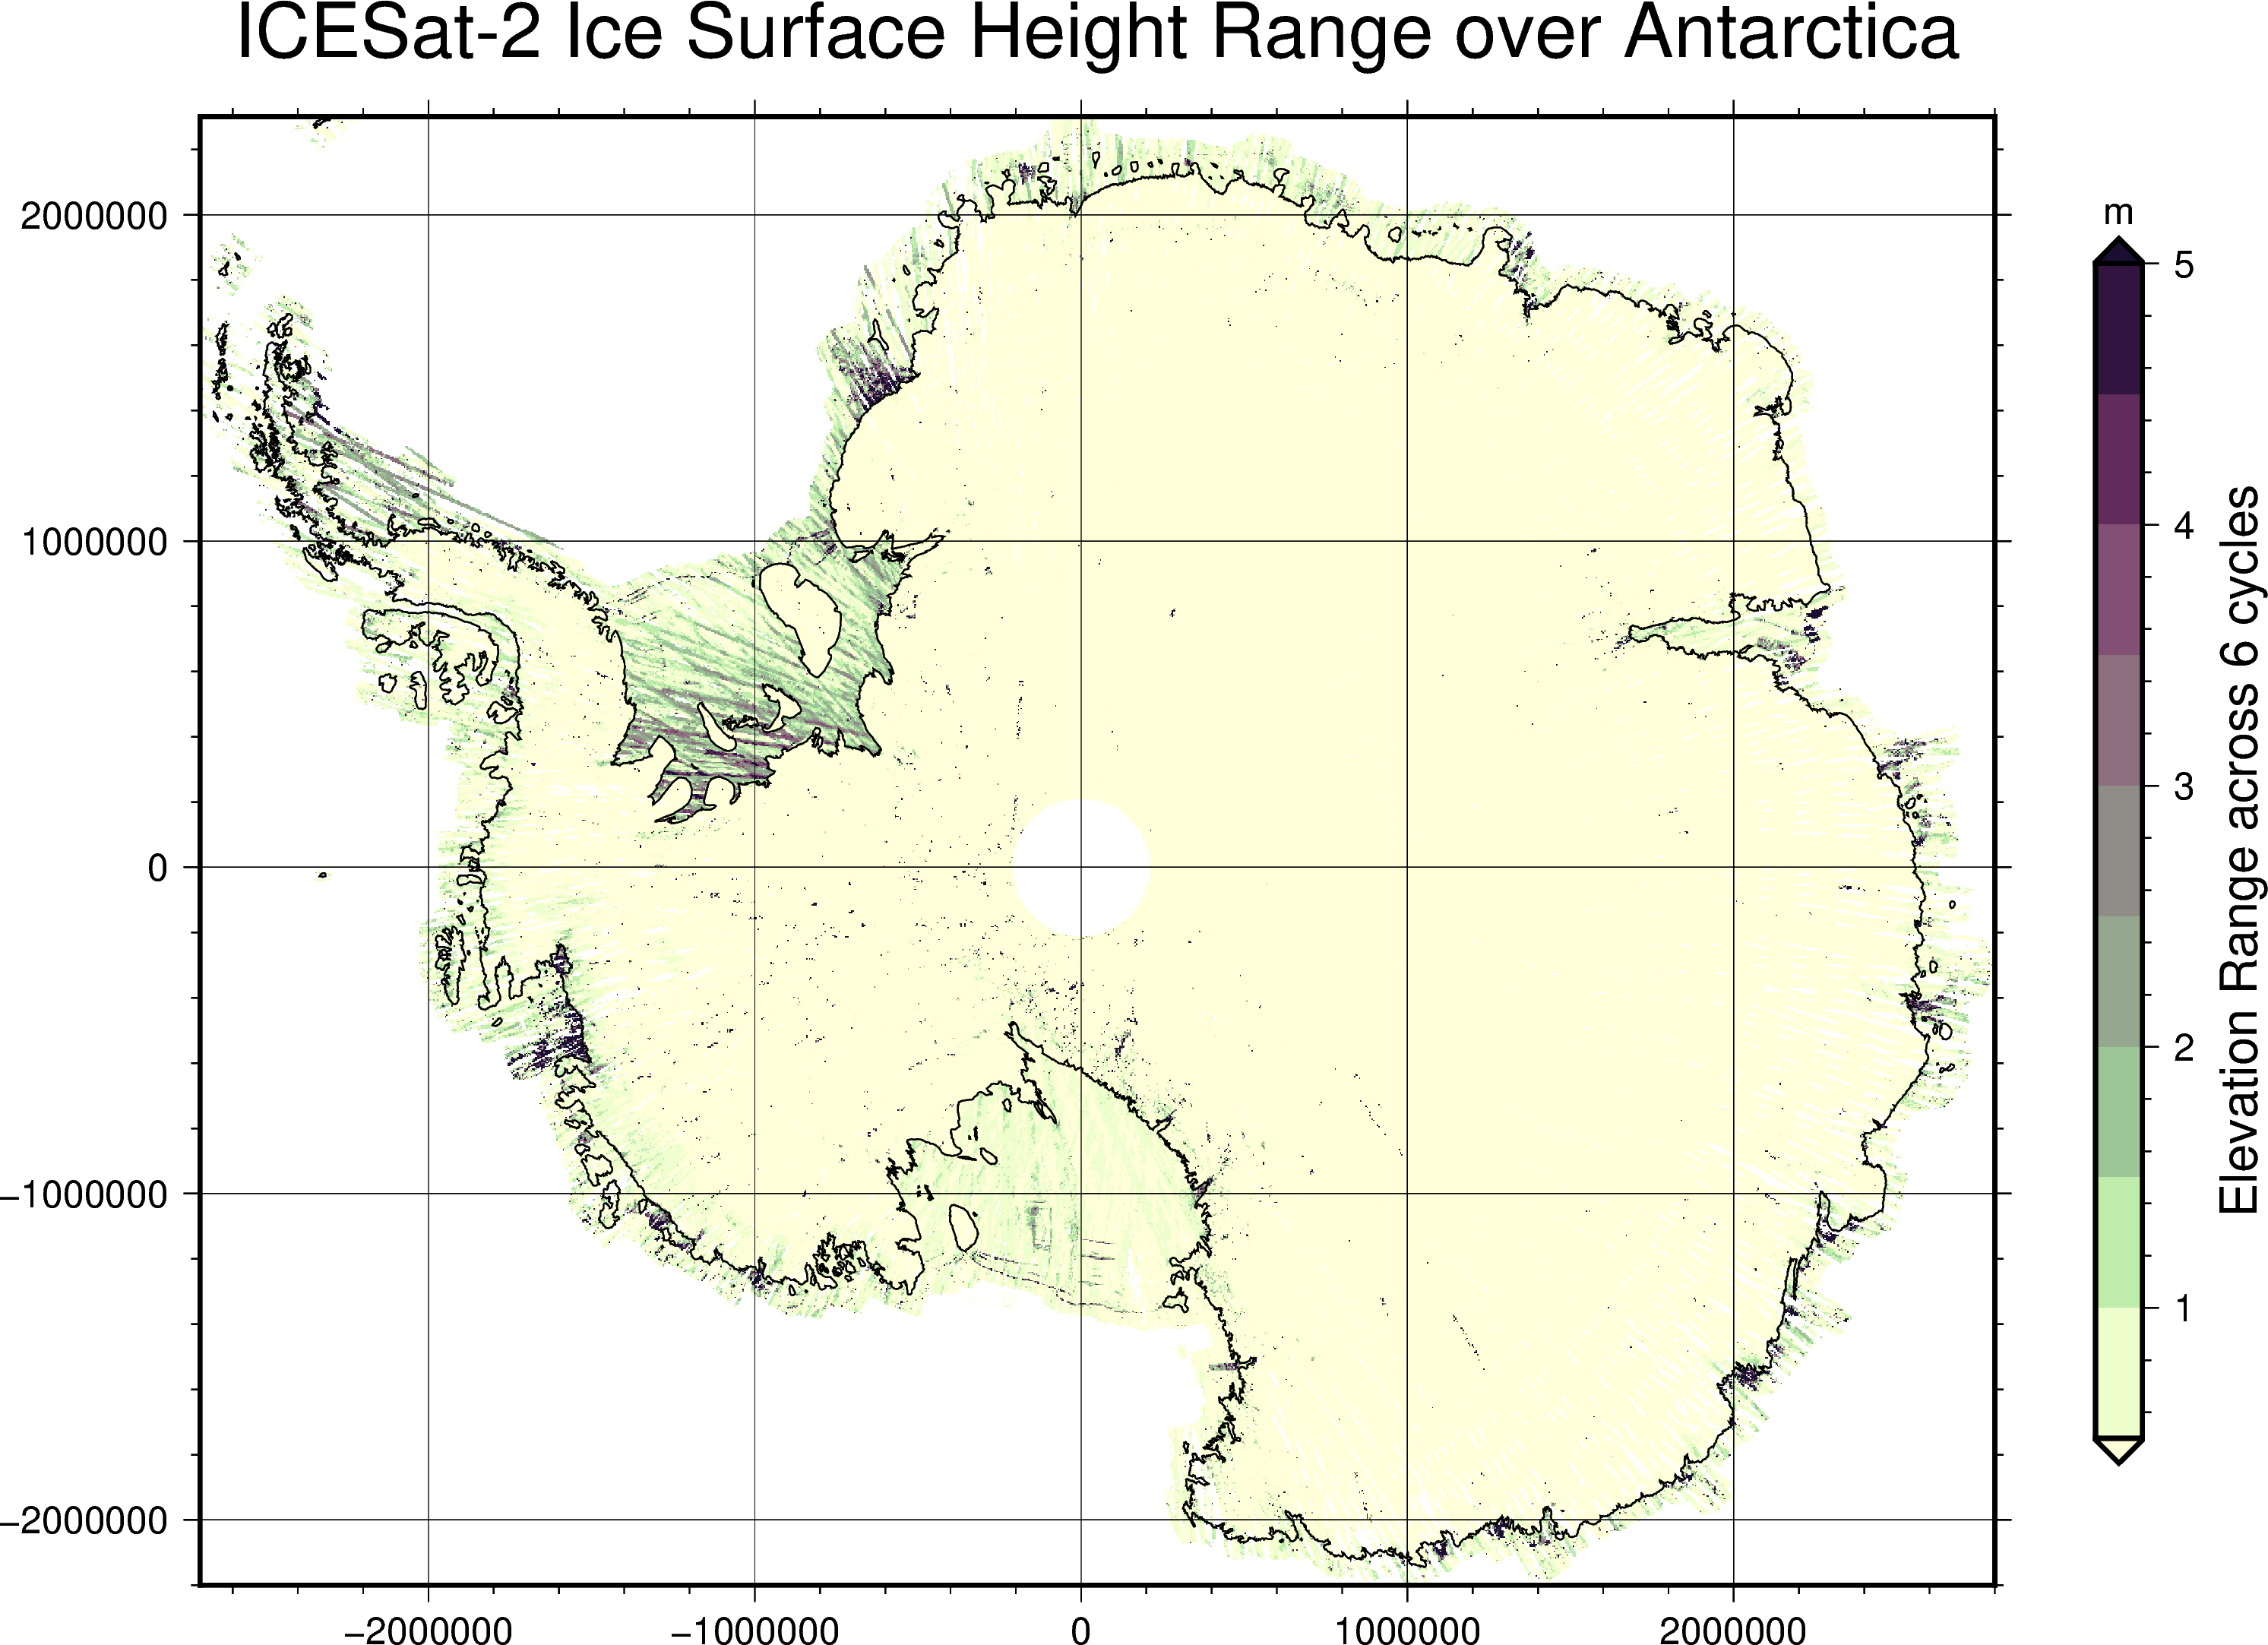

In [18]:
# Plot our map!
scale: int = region.scale
fig = pygmt.Figure()
pygmt.makecpt(cmap="tokyo", series=[0.5, 5, 0.5], reverse=True)
fig.grdimage(
    grid=agg_grid,
    region=region.bounds(),
    projection=f"x1:{scale}",
    frame=["afg", f'WSne+t"ICESat-2 Ice Surface Height Range over {region.name}"'],
    Q=True,
)
fig.colorbar(
    position="JCR+e", frame=["af", 'x+l"Elevation Range across 6 cycles"', "y+lm"],
)
# for subglacial_lake in subglacial_lakes:
#     fig.plot(data=subglacial_lake, L=True, pen="thin")
fig.coast(
    region=region.bounds(),
    projection=f"s0/-90/-71/1:{scale}",
    area_thresh="+ag",
    resolution="i",
    shorelines="0.5p",
    V="q",
)
fig.savefig(f"figures/plot_atl11_hrange_{placename}.png")
fig.show(width=600)

# Calculate rate of height change over time (dhdt)

Performing linear regression in parallel.
Uses the [`scipy.stats.linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) function,
parallelized with xarray's [`apply_ufunc`](http://xarray.pydata.org/en/v0.15.1/examples/apply_ufunc_vectorize_1d.html) method
on a Dask cluster.

In [19]:
# Take only the points where there is more than 0.5 metres of elevation change
# Trim down ~100 million points to ~10 million
ds = ds.where(cond=ds.h_range > 0.5, drop=True)
print(f"Trimmed to {len(ds.ref_pt)} points")

Trimmed to 9837731 points


In [20]:
# Do linear regression on many datapoints, parallelized using dask
dhdt_params: xr.DataArray = xr.apply_ufunc(
    deepicedrain.nan_linregress,
    ds.delta_time.astype(np.uint64),  # x is time in nanoseconds
    ds.h_corr,  # y is height in metres
    input_core_dims=[["cycle_number"], ["cycle_number"]],
    output_core_dims=[["dhdt_parameters"]],
    # output_core_dims=[["slope_ns"], ["intercept"], ["r_value"], ["p_value"], ["std_err"]],
    dask="parallelized",
    vectorize=True,
    output_dtypes=[np.float32],
    output_sizes={"dhdt_parameters": 5},
    # output_sizes={"slope_ns":1, "intercept":1, "r_value":1, "p_value":1, "std_err":1}
)

In [21]:
# Construct an xarray.Dataset containing time, height, and dhdt variables
ds_dhdt: xr.Dataset = ds[["delta_time", "h_corr"]]
for var_name, dataarray in zip(
    ["slope", "intercept", "r_value", "p_value", "std_err"], dhdt_params.transpose()
):
    ds_dhdt[f"dhdt_{var_name}"]: xr.DataArray = dataarray

In [22]:
# Convert dhdt_slope units from metres per nanosecond to metres per year
# 1 year = 365.25 days x 24 hours x 60 min x 60 seconds x 1_000_000_000 nanoseconds
ds_dhdt["dhdt_slope"] = ds_dhdt["dhdt_slope"] * (365.25 * 24 * 60 * 60 * 1_000_000_000)

In [23]:
# %%time
# Compute rate of height change over time (dhdt). Also include all height and time info
ds_dhdt: xr.Dataset = ds_dhdt.compute()

CPU times: user 3min 10s, sys: 33 s, total: 3min 42s
Wall time: 3min 42s


In [24]:
# Do linear regression on single datapoint
# slope_ns, intercept, r_value, p_value, std_err = nan_linregress(
#     x=ds.delta_time[:1].data.astype(np.uint64), y=ds.h_corr[:1].data
# )
# print(slope_ns, intercept, r_value, p_value, std_err)

In [25]:
# Load or Save rate of height change over time (dhdt) data
# ds_dhdt.to_zarr(store=f"ATLXI/ds_dhdt_{placename}.zarr", mode="w", consolidated=True)
ds_dhdt: xr.Dataset = xr.open_dataset(
    filename_or_obj=f"ATLXI/ds_dhdt_{placename}.zarr",
    chunks={"cycle_number": 6},
    engine="zarr",
    backend_kwargs={"consolidated": True},
)

In [26]:
df_slope: pd.DataFrame = ds_dhdt.dhdt_slope.to_dataframe()

In [ ]:
# Datashade our height values (vector points) onto a grid (raster image)
agg_grid: xr.DataArray = region.datashade(df=df_slope, z_dim="dhdt_slope")
agg_grid

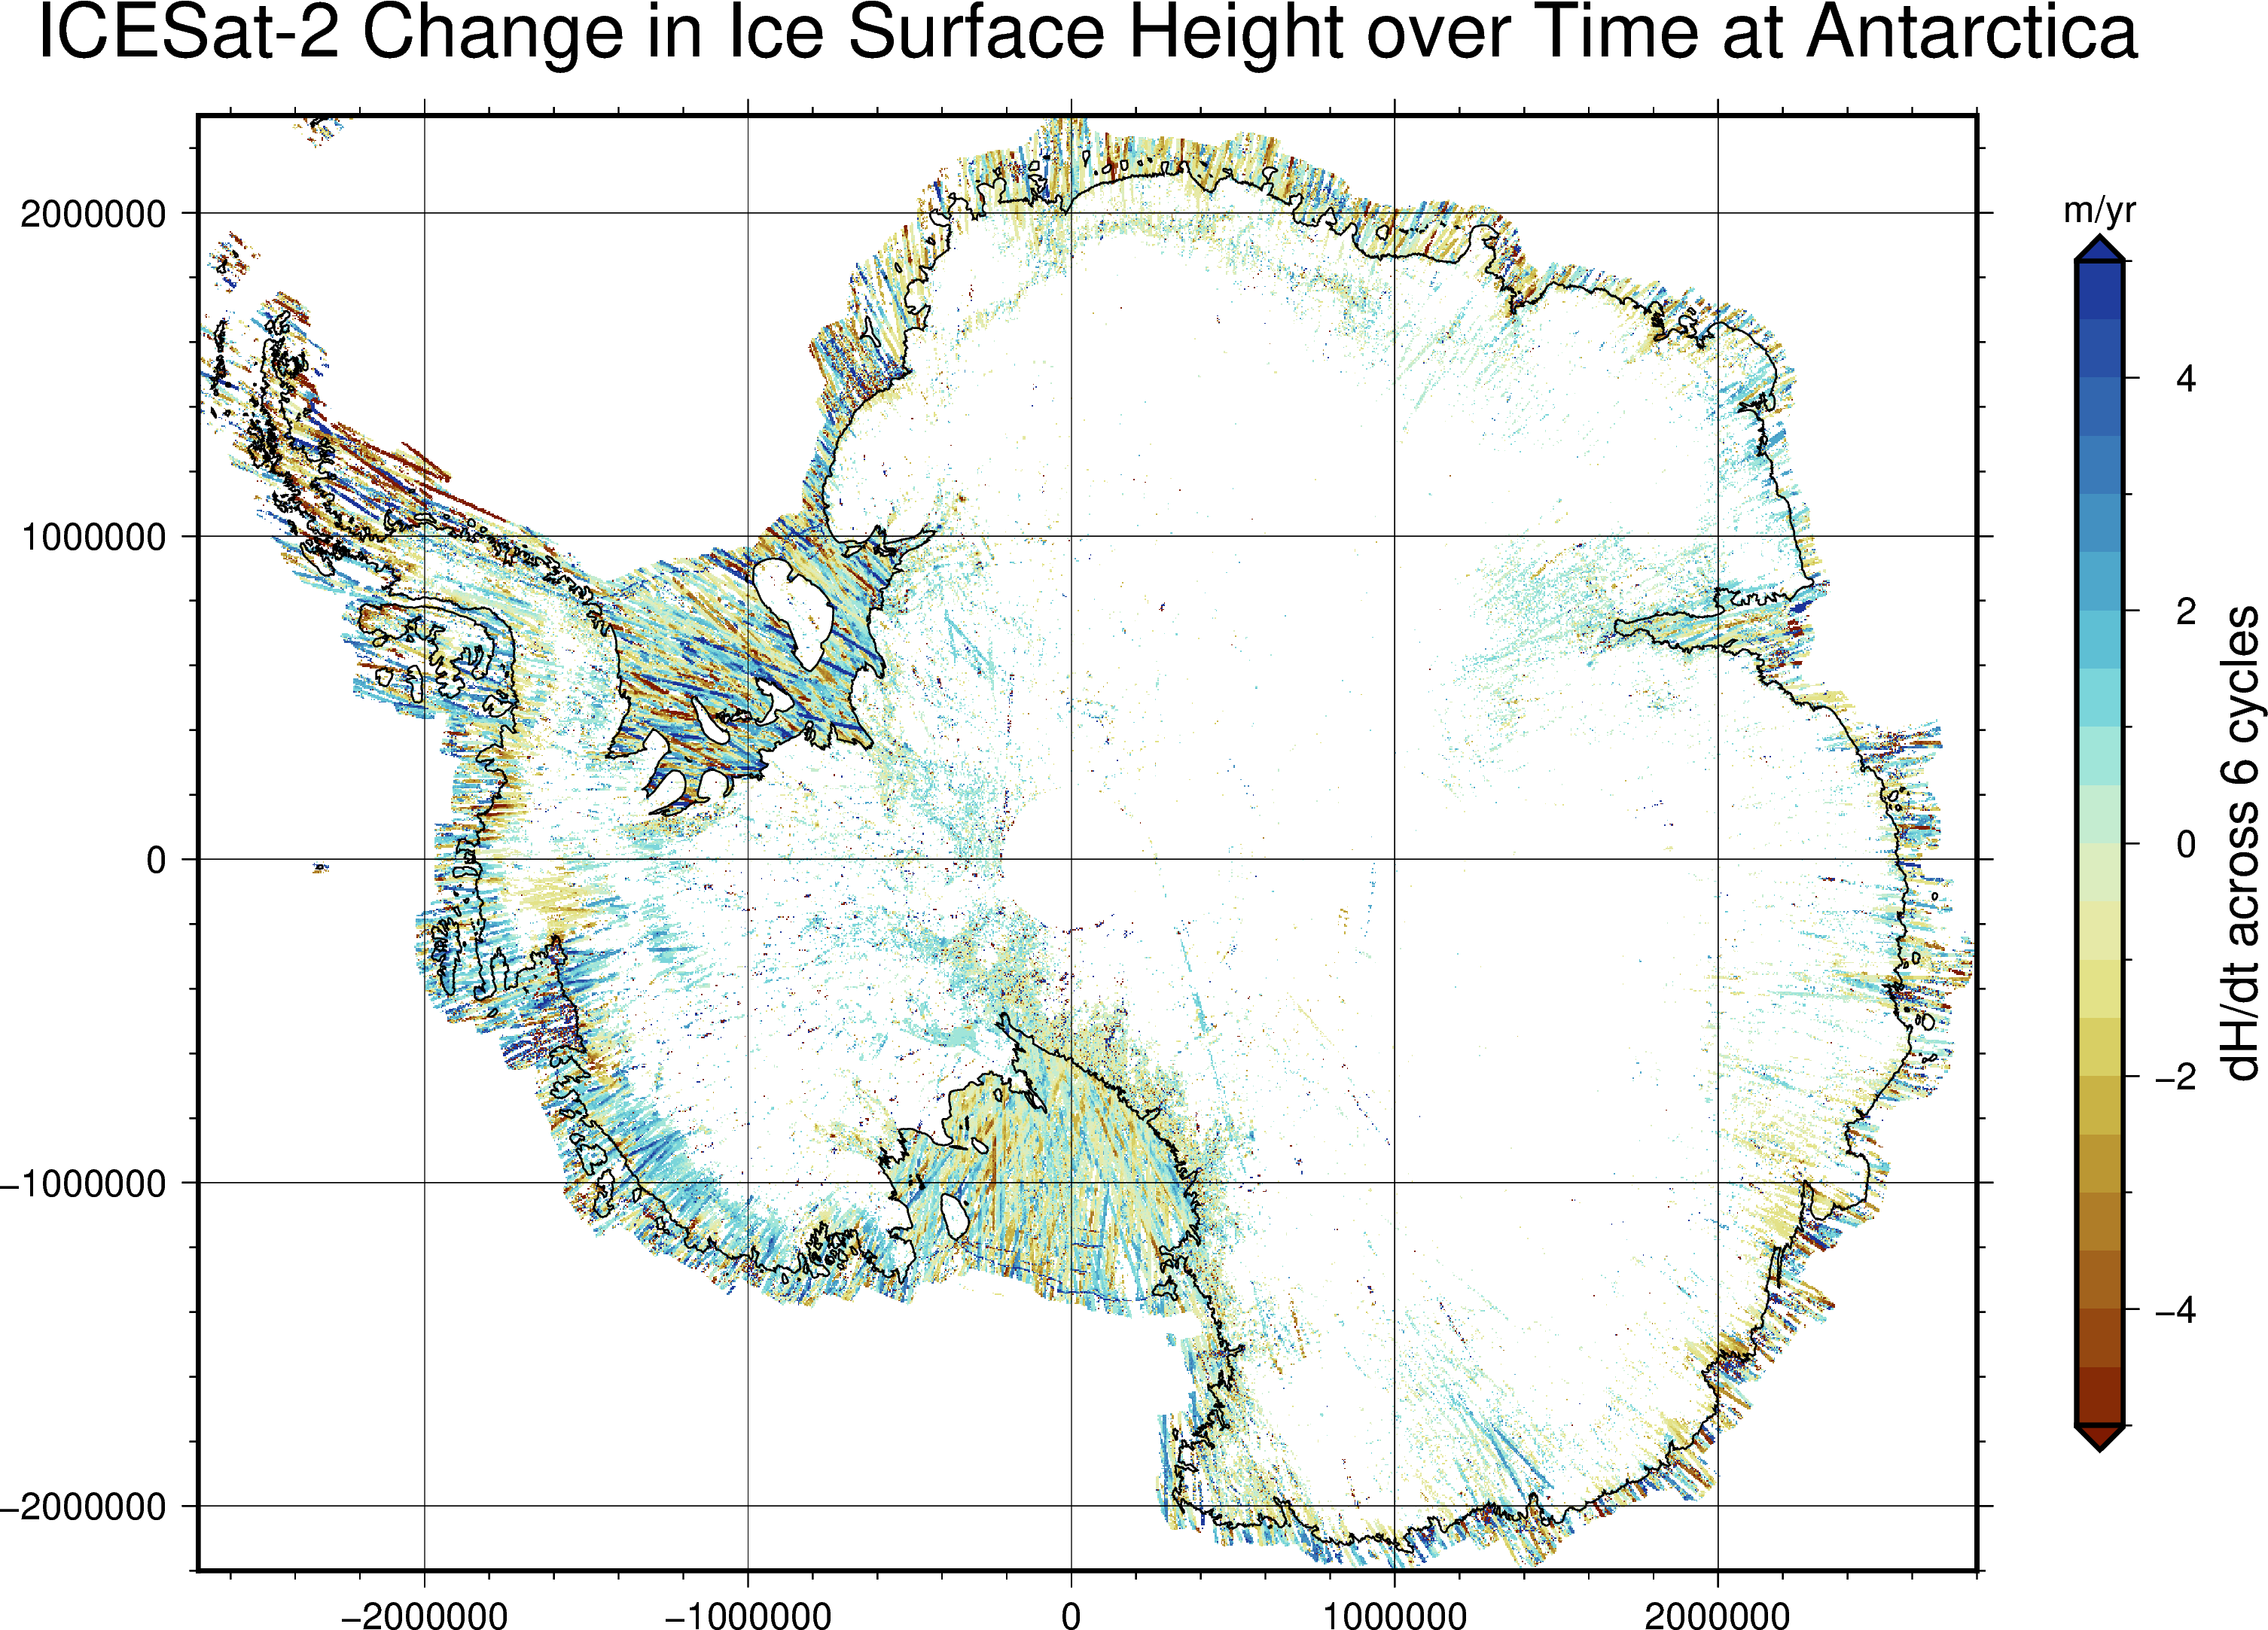

In [28]:
# Plot our map!
scale: int = region.scale
fig = pygmt.Figure()
pygmt.makecpt(cmap="roma", series=[-5, 5, 0.5])
fig.grdimage(
    grid=agg_grid,
    region=region.bounds(),
    projection=f"x1:{scale}",
    frame=[
        "afg",
        f'WSne+t"ICESat-2 Change in Ice Surface Height over Time at {region.name}"',
    ],
    Q=True,
)
fig.colorbar(
    position="JCR+e", frame=["af", 'x+l"dH/dt across 6 cycles"', "y+lm/yr"],
)
# for subglacial_lake in subglacial_lakes:
#    fig.plot(data=subglacial_lake, L=True, pen="thinnest")
fig.coast(
    region=region.bounds(),
    projection=f"s0/-90/-71/1:{scale}",
    area_thresh="+ag",
    resolution="i",
    shorelines="0.5p",
    V="q",
)
fig.savefig(f"figures/plot_atl11_dhdt_{placename}.png")
fig.show(width=600)